### 1 ) 라이브러리 호출

In [1]:
import os, cv2, dlib, math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = '/aiffel/aiffel/Face_landmark/front.jpg'

### 2 ) 셀카 이미지 호출

#### cv2는 RGB가 아닌 BGR로 색상을 받는다.

In [3]:
from copy import deepcopy

In [4]:
img_bgr = cv2.imread(file_path)

In [5]:
img_bgr

array([[[177, 210, 219],
        [178, 211, 220],
        [178, 211, 220],
        ...,
        [146, 182, 190],
        [146, 182, 190],
        [146, 182, 190]],

       [[178, 211, 220],
        [179, 212, 221],
        [179, 212, 221],
        ...,
        [146, 182, 190],
        [146, 182, 190],
        [146, 182, 190]],

       [[179, 212, 221],
        [179, 212, 221],
        [179, 212, 221],
        ...,
        [146, 182, 190],
        [147, 183, 191],
        [147, 183, 191]],

       ...,

       [[187, 199, 201],
        [187, 199, 201],
        [187, 199, 201],
        ...,
        [175, 191, 197],
        [176, 192, 198],
        [176, 192, 198]],

       [[180, 192, 196],
        [181, 193, 197],
        [182, 193, 197],
        ...,
        [173, 190, 193],
        [173, 190, 193],
        [173, 190, 193]],

       [[176, 191, 194],
        [176, 191, 194],
        [179, 190, 194],
        ...,
        [170, 187, 190],
        [170, 187, 190],
        [170, 187, 190]]

In [6]:
img_show = deepcopy(img_bgr)

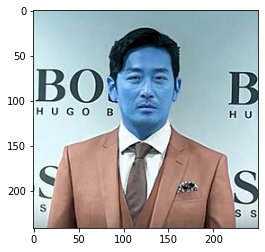

In [7]:
plt.imshow(img_show)

#### cv2.cvtColor(cv2.COLOR_BGR2RGB)로 색상 채널 변경

In [8]:
img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

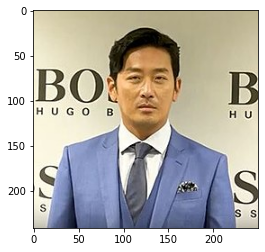

In [9]:
plt.imshow(img_rgb)

#### HOG detector 선언

In [10]:
detector_hog = dlib.get_frontal_face_detector()

#### 얼굴 이미지 바운딩 박스 추출

In [11]:
dlib_rects = detector_hog(img_rgb, 1)

In [12]:
dlib_rects

rectangles[[(88, 55) (162, 130)]]

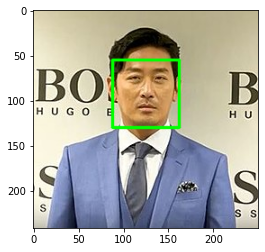

In [13]:
for dlib_rect in dlib_rects: # 얼굴이 하나기때문에 사실 for문을 돌려야 할 이유는 없다.
    l = dlib_rect.left() # 바운딩 박스의 제일 왼쪽
    t = dlib_rect.top() # 바운딩 박스의 제일 위쪽
    r = dlib_rect.right() # 바운딩 박스의 제일 오른쪽
    b = dlib_rect.bottom() # 바운딩 박스의 제일 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### Face Landmark

In [14]:
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [15]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) # img_rgb의 dlib_rect 객체 내에서 landmark를 찾는다.
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) # x,y좌표를 리스트 형태로 list_points에 저장
    list_landmarks.append(list_points) # list_landmarks에 저장

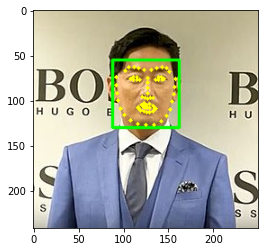

In [16]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 왜 w, h를 다같이 width에 설정시킨 것일까??? 어차피 width, height 동일하니까 이대로 작성한 것 같다.

In [17]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[8])
    x = landmark[8][0] + 1
    y = landmark[8][1] + 5
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(125, 127)
(x,y) : (126,132)
(w,h) : (75,75)


### 3 ) 스티커 이미지 호출

In [18]:
sticker_path = '/aiffel/aiffel/Face_landmark/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) 
print (img_sticker.shape) 

(75, 75, 3)


In [19]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

(x,y) : (89,57)


In [20]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (89,57)


In [21]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,cv2.addWeighted(src1=sticker_area, src2=img_sticker, alpha=0.7, beta=0.3, gamma=0), cv2.addWeighted(src1=sticker_area, src2=img_sticker, alpha=1, beta=0, gamma=0)).astype(np.uint8)

### 4 ) 스티커 이미지 적용하기

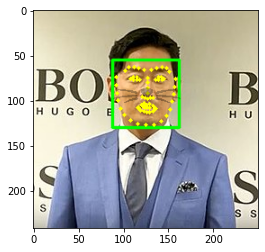

In [22]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

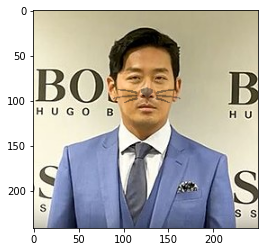

In [23]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,cv2.addWeighted(src1=sticker_area, src2=img_sticker, alpha=0.6, beta=0.4, gamma=0), cv2.addWeighted(src1=sticker_area, src2=img_sticker, alpha=1, beta=0, gamma=0)).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 5 ) 문제점 찾아보기

#### 다양한 얼굴 각도

In [142]:
def sticker(a, x_, y_, rotate=None, cut_x = 1, cut_y = 1):
    img_bgr = a.copy()
    img_show = deepcopy(img_bgr)
    img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img_bgr, 1)
    for dlib_rect in dlib_rects: # 얼굴이 하나기때문에 사실 for문을 돌려야 할 이유는 없다.
        l = dlib_rect.left() # 바운딩 박스의 제일 왼쪽
        t = dlib_rect.top() # 바운딩 박스의 제일 위쪽
        r = dlib_rect.right() # 바운딩 박스의 제일 오른쪽
        b = dlib_rect.bottom() # 바운딩 박스의 제일 아래쪽
        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect) # img_rgb의 dlib_rect 객체 내에서 landmark를 찾는다.
        list_points = list(map(lambda p: (p.x, p.y), points.parts())) # x,y좌표를 리스트 형태로 list_points에 저장
        list_landmarks.append(list_points) # list_landmarks에 저장
        
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)

    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
        x = landmark[8][0] + x_
        y = landmark[8][1] + y_
        w = h = dlib_rect.width()
        
    sticker_path = '/aiffel/aiffel/Face_landmark/cat_whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h)) 

    
    # 스티커 사진 Rotation을 위한 코드
    def RotateImage(img, angle, scale=1):
        if img.ndim > 2:
            height, width, channel = img.shape
        else:
            height, width = img.shape

        matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, scale)
        result = cv2.warpAffine(img, matrix, (width, height), dst=None, flags= cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255) )

        return result

    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w, h))
    
    print(int(img_sticker.shape[0] * cut_x))
    print(int(img_sticker.shape[1] * cut_y))
    img_sticker[int(img_sticker.shape[0] * cut_x):, :int(img_sticker.shape[1] * cut_y)] = 255
    rad = 20 * math.pi / 180# 각도 설정
    img_sticker = RotateImage(img_sticker, rotate, 1)
    
    plt.imshow(img_sticker)
    plt.show()
        
    refined_x = x - w // 2
    refined_y = y - h
    
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0
        
    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0,cv2.addWeighted(src1=sticker_area, src2=img_sticker, alpha=0.5, beta=0.5, gamma=0), cv2.addWeighted(src1=sticker_area, src2=img_sticker, alpha=1, beta=0, gamma=0)).astype(np.uint8)
    
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0,cv2.addWeighted(src1=sticker_area, src2=img_sticker, alpha=0.5, beta=0.5, gamma=0), cv2.addWeighted(src1=sticker_area, src2=img_sticker, alpha=1, beta=0, gamma=0)).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

#### 웃는 표정은 큰 문제가 되지 않았다.

130
130


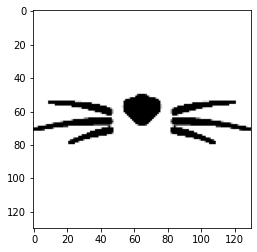

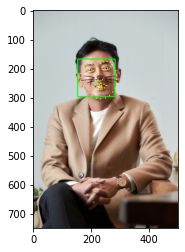

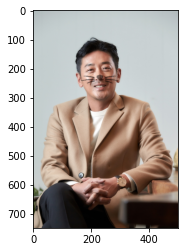

In [143]:
file_path = '/aiffel/aiffel/Face_landmark/smile.jpeg'
img_bgr = cv2.imread(file_path)
sticker(img_bgr, -3, -3)

#### 얼굴을 손으로 가려도 큰 문제가 되지 않았다.

186
186


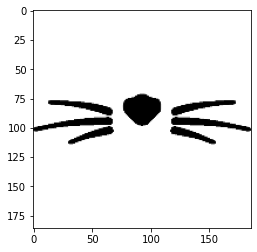

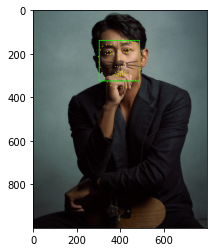

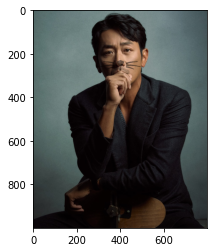

In [144]:
file_path = '/aiffel/aiffel/Face_landmark/occulusion.jpeg'
img_bgr = cv2.imread(file_path)
sticker(img_bgr, -3, -13)

#### 약간 위를 쳐다봐도 큰 문제는 없었다.

224
224


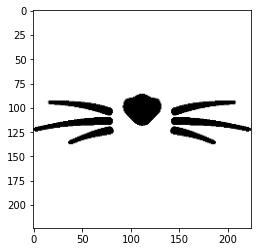

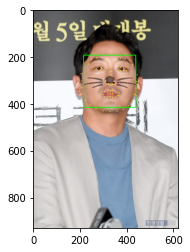

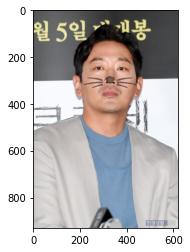

In [145]:
file_path = '/aiffel/aiffel/Face_landmark/upper.jpg'
img_bgr = cv2.imread(file_path)
sticker(img_bgr, 0, -15)

#### 측면을 바라보게 되면 약간의 왜곡이 생기기 시작하였다.

156
156


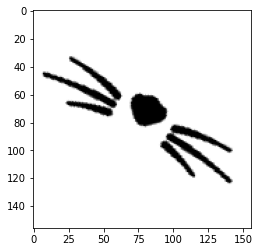

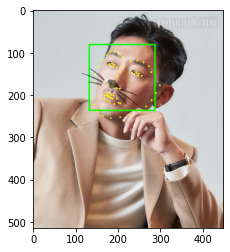

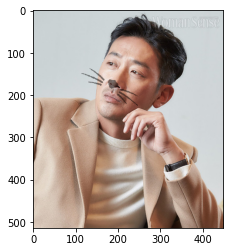

In [146]:
file_path = '/aiffel/aiffel/Face_landmark/left.jpeg'
img_bgr = cv2.imread(file_path)
sticker(img_bgr, 20, 10, rotate=-30)

#### 완전 측면은 face detector로써의 기능을 상실했다고 봐도 무방할 정도로 나쁜 mark를 보여준다.

0
52


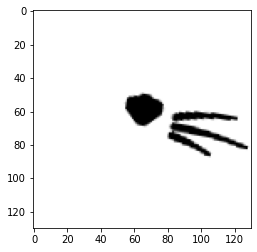

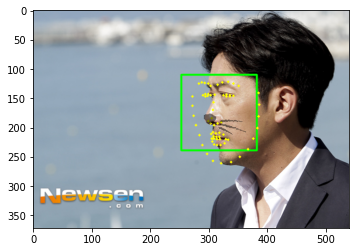

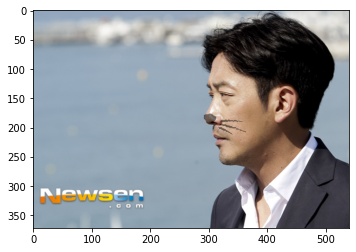

In [149]:
file_path = '/aiffel/aiffel/Face_landmark/c_left.jpeg'
img_bgr = cv2.imread(file_path)
sticker(img_bgr, -20, -5, rotate=-10, cut_x=0, cut_y=0.4)

#### 문제점

- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?

얼굴각도에 따라 스티커도 그만큼 회전해야 자연스러운 이미지 합성이 가능해질 것이다. 하지만, 이 회전 각은 원본이미지에 비례하여 계속 바뀌어야한다는 문제점이 있다.

- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?

추측하기로는 hog detector는 정면을 기준으로 학습이 된것 같다. 따라서, 옆으로 누우면 눈이 90도 회전하여 인식 못하는 것 같고, 멀리 있으면 눈자체를 인식하지 못하는 것같다.

- 실행 속도가 중요할까요?

앱을 만들어 배포할 계획이라면 실행속도가 아주 중요할 것이다.

- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

정확하지 않으면 스티커앱을 사용하는 유저가 감소하는 건 당연하므로 정확도는 높으면 높을수록 좋다. 다만, 실행속도와 trade off 관계를 고려하여 최선의 정확도를 내는 모델을 구현하는 것이 중요할 것이다.

### 6 ) 회고

<br>
- 이번 face landmark를 통해서 약간이나마 이미지 합성을 배울 수 있어서 뜻 깊었다.
<br>

- Hog Detector의 문제점을 파악하였고, 이러한 현상을 해결하기 위해 딥러닝 모델은 어떤 방식을 취했는지 알아볼 계획이다.
<br>

- land mark가 이미지 생성 모델의 하나의 feature로 사용될 수 있다면 성능이 개선될 수 있지 않을까하는 궁금점이 생겨 공부해 볼 계획이다.